In [103]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Density = pd.read_csv('~/Documents/NYCDSA/Capstone/Density_Atlanta/Density_Atlanta.csv')
Atlanta_Density['Total Bathrooms'] = Atlanta_Density['number_of_full_baths'] + (Atlanta_Density['number_of_half_baths']*0.5)
Atlanta_Density = Atlanta_Density.drop(columns=['latitude',
                                                  'longitude', 'number_of_full_baths', 'number_of_half_baths'])
Atlanta_Density = Atlanta_Density.rename(columns={'SM_One': 'Supermarket (One Mile)', 'C_One': 'Convenience (One Mile)',
'WS_One': 'Wholesale (One Mile)', 'VS_One': 'Variety Store (One Mile)', 'SC_One': 'Supercenter (One Mile)', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                   'lot_size_in_square_feet': 'Lot Size(SQF)', 'number_of_garage_spaces': 'Garage Spaces', 'number_of_stories': 'Stories',
                                                   'SM_Five': 'Supermarket (Five Miles)', 'C_Five': 'Convenience (Five Miles)', 'year_built': 'Year Built',
'WS_Five': 'Wholesale (Five Miles)', 'VS_Five': 'Variety Store (Five Miles)', 'SC_Five': 'Supercenter (Five Miles)',
                                                 'WS_Three': 'Wholesale (Three Miles)', 'VS_Three': 'Variety Store (Three Miles)',
                                                  'SM_Three': 'Supermarket (Three Miles)', 'SC_Three': 'Supercenter (Three Miles)', 'C_Three': 'Convenience (Three Miles)'})
Atlanta_Density['Year Built'] = Atlanta_Density['Year Built'].astype('Int64') #For numerical analysis: Use int or float if there are missing values
Atlanta_Density_One = Atlanta_Density.drop(columns=['Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)',
                                                   'Wholesale (Three Miles)','Variety Store (Three Miles)','Supermarket (Three Miles)', 'Supercenter (Three Miles)','Convenience (Three Miles)'])
Atlanta_Density_One

,street_address,current_listing_price,Year Built,Total Bedrooms,Living Area(SQF),Convenience (One Mile),Supercenter (One Mile),Supermarket (One Mile),Variety Store (One Mile),Wholesale (One Mile),Total Bathrooms
0,0 ivy MNR DR NW 0,2865,2002,4,3259.0,0,0,0,0,0,2.5
1,1 10 buena VIS CIR SE,2200,<NA>,3,1993.0,2,1,0,2,0,2.0
2,1 1088 coldwater DR,2000,<NA>,3,1910.0,0,0,0,0,0,2.0
3,1 1130 willivee DR,1995,<NA>,3,1134.0,0,0,0,0,0,1.0
4,1 1307 idlewood CT,2800,<NA>,4,2532.0,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
21010,procurement only - 66 4th ST,1600,<NA>,3,1367.0,0,0,0,0,0,2.0
21011,r2188 executive DR,2199,<NA>,3,1696.0,1,0,1,0,0,2.5
21012,r3339 woodward down,2380,2015,3,1944.0,0,1,1,1,1,3.5
21013,singleunit 216 greensprings DR,1900,<NA>,4,1204.0,1,0,0,1,0,2.0


In [104]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Density_One.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

In [105]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [106]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Density_One)

In [107]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (One Mile)',
 'Supercenter (One Mile)',
 'Supermarket (One Mile)',
 'Variety Store (One Mile)',
 'Wholesale (One Mile)',
 'Total Bathrooms']

In [108]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df.loc[447:447]

,Year Built,Total Bedrooms,Living Area(SQF),Convenience (One Mile),Supercenter (One Mile),Supermarket (One Mile),Variety Store (One Mile),Wholesale (One Mile),Total Bathrooms
447,-1.091762e-14,0.641662,-0.707015,-0.376706,-0.229536,-0.527769,-0.41141,-0.093726,-0.47568


In [109]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
# Assuming XGB is part of your models dictionary
xgb_model = XGBRegressor(random_state=42)
# Define the full model pipeline including the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])
X = Atlanta_Density_One.drop(columns='current_listing_price')
y = Atlanta_Density_One['current_listing_price']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Fit the model pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (One Mile)', 'Supercenter (One Mile)',
       'Supermarket (One Mile)', 'Variety Store (One Mile)',
       'Wholesale (One Mile)', 'Total Bathrooms'],
      dtype='object'))...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [110]:
val_score = pipeline.score(X_val, y_val) #0.6137914878103629
print('Validation R^2:', val_score)

test_score = pipeline.score(X_test, y_test) #0.55202185736604
print('Test R^2:', test_score)

Validation R^2: 0.44538289308547974
Test R^2: 0.48237937688827515


In [111]:
from sklearn.metrics import mean_squared_error #average squared difference between predicted and actual values
#When comparing different models, 
#the one with the lowest MSE on the validation or test set is generally considered to be the better model for predicting the target variable.

#Low RMSE values show that the model makes more accurate predictions and fits the data well
y_val_pred = pipeline.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

y_test_pred = pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

Validation Mean Squared Error: 463042.2553207142
Validation Root Mean Squared Error: 680.4720826901822
Test Mean Squared Error: 441858.97183182294
Test Root Mean Squared Error: 664.7247338799896


In [112]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val, y_val_pred)
test_mape = calculate_mape(y_test, y_test_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape) #A lower MAPE value indicates a more accurate prediction

Validation Mean Absolute Percentage Error (MAPE): 16.77075594282018
Test Mean Absolute Percentage Error (MAPE): 16.754695621773735


In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
param_grid = {
    'regressor__n_estimators': [200],       # Number of trees
    'regressor__learning_rate': [0.1],     # Learning rate (shrinkage)
    'regressor__max_depth': [4],                # Maximum depth of the trees
    'regressor__subsample': [0.7],               # Fraction of samples to be used per tree
    'regressor__colsample_bytree': [0.7], # Fraction of features to be used per tree
    'regressor__alpha': [20], 
    'regressor__gamma': [1]                 # Minimum loss reduction for a split
}

grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=10,
                           scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
                           refit='r2',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Access the results
results = grid_search.cv_results_
print("Best parameters:", grid_search.best_params_)
print("Best R^2:", grid_search.best_score_)


mean_r2_scores = results['mean_test_r2']
mean_mse_scores = -results['mean_test_neg_mean_squared_error']
mean_mape_scores = -results['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores = -results['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores)
print("Mean MAPE scores:", mean_mape_scores)
print("Mean R^2 scores:", mean_r2_scores)
print("Mean RMSE scores:", mean_RMSE_scores)

Best parameters: {'regressor__alpha': 20, 'regressor__colsample_bytree': 0.7, 'regressor__gamma': 1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 200, 'regressor__subsample': 0.7}
Best R^2: 0.491225802898407
Mean MSE scores: [417104.23083784]
Mean MAPE scores: [0.16685536]
Mean R^2 scores: [0.4912258]
Mean RMSE scores: [644.91883192]


In [114]:
def calculate_scores(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return r2, mse, mape, rmse

In [115]:
#best_model.fit(X_train_val, y_train_val)

y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val, y_val_pred_tuned)

y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test, y_test_pred_tuned)

y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_train_val, y_combined_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Test-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")
#Refitted model may be causing data leakage, and therefore different results. Differences can be ignored

Tuned Validation Set Scores:
R²: 0.4747
MSE: 438598.0321
MAPE: 0.1641
RMSE: 662.2673

Tuned Test Set Scores:
R²: 0.4833
MSE: 441114.6293
MAPE: 0.1674
RMSE: 664.1646

Tuned Test-Val Set Scores:
R²: 0.5766
MSE: 349099.7736
MAPE: 0.1566
RMSE: 590.8467


In [116]:
best_xgb_model = best_model.named_steps['regressor']
feature_importances = best_xgb_model.feature_importances_

In [117]:
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

In [118]:
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Total Bathrooms, Importance: 0.2462
Feature: Living Area(SQF), Importance: 0.2403
Feature: Convenience (One Mile), Importance: 0.1135
Feature: Supermarket (One Mile), Importance: 0.1055
Feature: Total Bedrooms, Importance: 0.0882
Feature: Year Built, Importance: 0.0840
Feature: Variety Store (One Mile), Importance: 0.0577
Feature: Supercenter (One Mile), Importance: 0.0391
Feature: Wholesale (One Mile), Importance: 0.0255


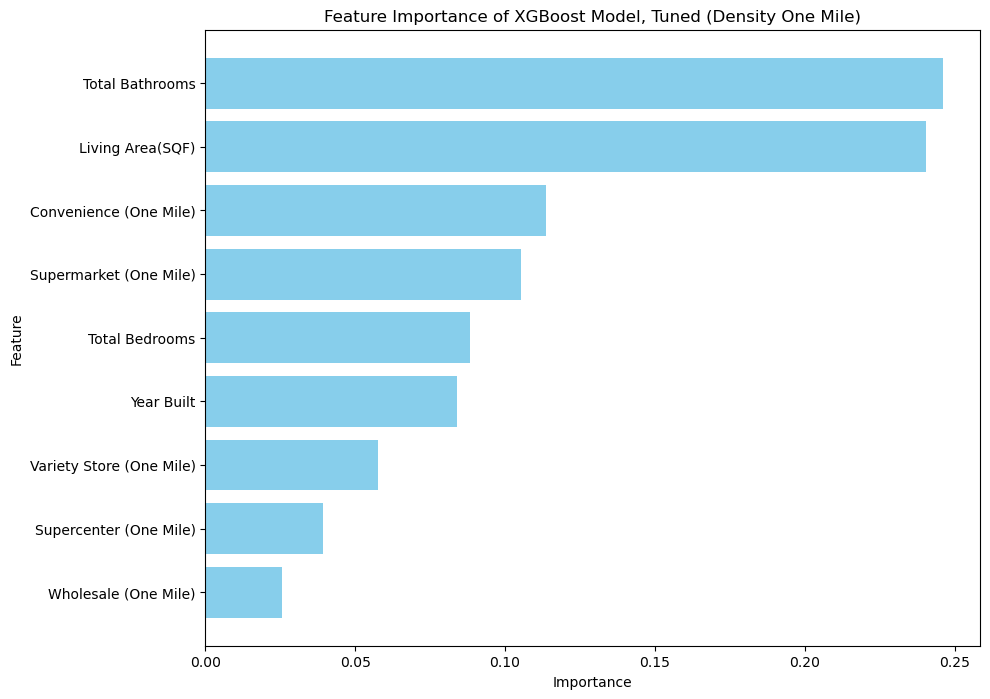

In [119]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Density One Mile)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [120]:
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (One Mile)',
 'Supercenter (One Mile)',
 'Supermarket (One Mile)',
 'Variety Store (One Mile)',
 'Wholesale (One Mile)',
 'Total Bathrooms']

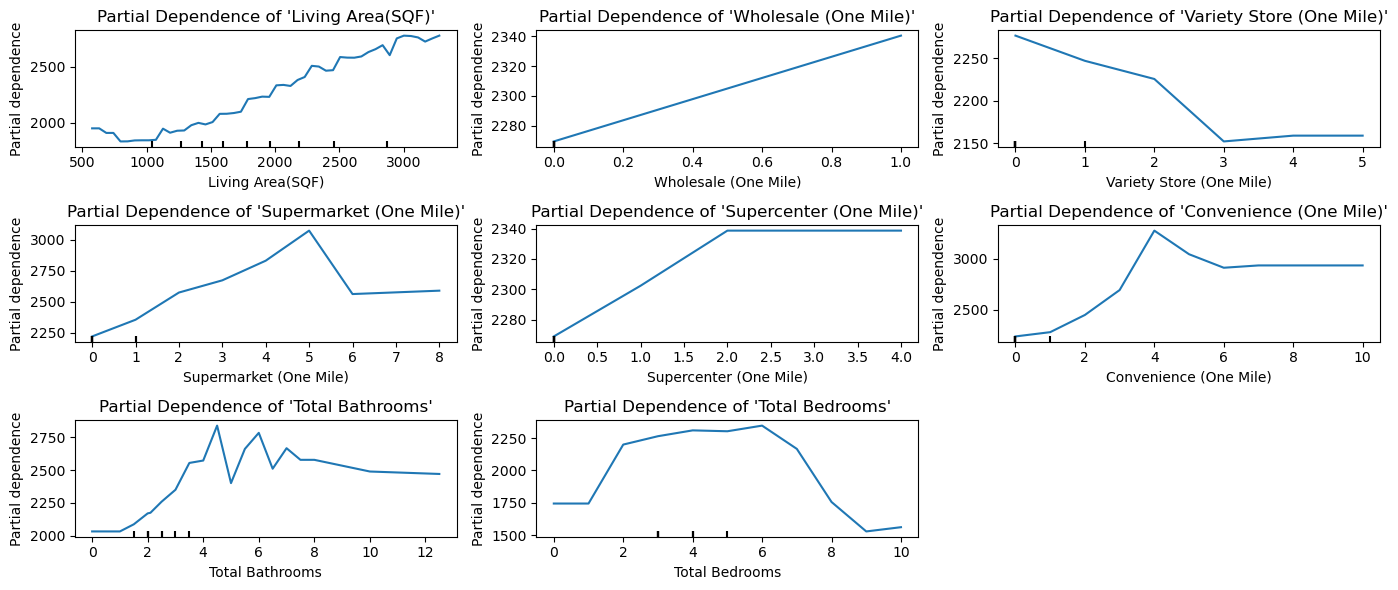

In [121]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import math

# List of features to include in the Partial Dependence Plots
features = [
 'Living Area(SQF)', 'Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 
    'Supercenter (One Mile)', 'Convenience (One Mile)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train_val,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [122]:
Atlanta_Density_Three = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)',
                                                      'Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)'])
numeric_features_three = Atlanta_Density_Three.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer_three = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric and nominal
preprocessor_three = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_three, numeric_features_three),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data_three = preprocessor_three.fit_transform(Atlanta_Density_Three)

In [123]:
# Combine all feature names
all_feature_names_three = list(numeric_features_three)
transformed_df_three = pd.DataFrame(transformed_data_three, columns=all_feature_names_three)

In [124]:
# Assuming RandomForest is part of your models dictionary
xgb_model_three = XGBRegressor(random_state=42)
# Define the full model pipeline including the preprocessor
pipeline_three = Pipeline([
    ('preprocessor', preprocessor_three),
    ('regressor', xgb_model_three)
])
X_three = Atlanta_Density_Three.drop(columns='current_listing_price')
y_three = Atlanta_Density_Three['current_listing_price']

X_train_val_three, X_test_three, y_train_val_three, y_test_three = train_test_split(X_three, y_three, test_size=0.2, random_state=42)
X_train_three, X_val_three, y_train_three, y_val_three = train_test_split(X_train_val_three, y_train_val_three, test_size=0.25, random_state=42)

# Fit the model pipeline
pipeline_three.fit(X_train_three, y_train_three)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Wholesale (Three Miles)', 'Variety Store (Three Miles)',
       'Supermarket (Three Miles)', 'Supercenter (Three Miles)',
       'Convenience (Three Miles)', 'Total Bathrooms'],
      d...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [125]:
val_score_three = pipeline_three.score(X_val_three, y_val_three)
print('Validation R^2:', val_score_three)

test_score_three = pipeline_three.score(X_test_three, y_test_three)
print('Test R^2:', test_score_three)

Validation R^2: 0.612326443195343
Test R^2: 0.5633878707885742


In [126]:
param_grid_three = {
    'regressor__n_estimators': [500],       # Number of trees
    'regressor__learning_rate': [0.1],     # Learning rate (shrinkage)
    'regressor__max_depth': [3],                # Maximum depth of the trees
    'regressor__subsample': [1.0],               # Fraction of samples to be used per tree
    'regressor__colsample_bytree': [0.7],        # Fraction of features to be used per tree
    'regressor__alpha': [20],
    'regressor__gamma': [0.5]                # Minimum loss reduction for a split
}

grid_search_three = GridSearchCV(pipeline_three,
                           param_grid_three,
                           cv=10,
                           scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
                           refit='r2',
                           n_jobs=-1)

grid_search_three.fit(X_train_three, y_train_three)

best_model_three = grid_search_three.best_estimator_

# Access the results
results_three = grid_search_three.cv_results_
print("Best parameters:", grid_search_three.best_params_)
print("Best R^2:", grid_search_three.best_score_)


mean_r2_scores_three = results_three['mean_test_r2']
mean_mse_scores_three = -results_three['mean_test_neg_mean_squared_error']
mean_mape_scores_three = -results_three['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores_three = -results_three['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores_three)
print("Mean MAPE scores:", mean_mape_scores_three)
print("Mean R^2 scores:", mean_r2_scores_three)
print("Mean RMSE scores:", mean_RMSE_scores_three)

Best parameters: {'regressor__alpha': 20, 'regressor__colsample_bytree': 0.7, 'regressor__gamma': 0.5, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 500, 'regressor__subsample': 1.0}
Best R^2: 0.5699203193187714
Mean MSE scores: [352030.57281094]
Mean MAPE scores: [0.15140925]
Mean R^2 scores: [0.56992032]
Mean RMSE scores: [592.6553457]


In [127]:
y_val_pred_tuned_three = best_model_three.predict(X_val_three)
val_scores_three = calculate_scores(y_val_three, y_val_pred_tuned_three)

y_test_pred_tuned_three = best_model_three.predict(X_test_three)
test_scores_three = calculate_scores(y_test_three, y_test_pred_tuned_three)

y_combined_pred_tuned_three = best_model_three.predict(X_train_val_three)
combined_scores_three = calculate_scores(y_train_val_three, y_combined_pred_tuned_three)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_three[0]:.4f}")
print(f"MSE: {val_scores_three[1]:.4f}")
print(f"MAPE: {val_scores_three[2]:.4f}")
print(f"RMSE: {val_scores_three[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_three[0]:.4f}")
print(f"MSE: {test_scores_three[1]:.4f}")
print(f"MAPE: {test_scores_three[2]:.4f}")
print(f"RMSE: {test_scores_three[3]:.4f}")

print("\nTuned Test-Val Set Scores:")
print(f"R²: {combined_scores_three[0]:.4f}")
print(f"MSE: {combined_scores_three[1]:.4f}")
print(f"MAPE: {combined_scores_three[2]:.4f}")
print(f"RMSE: {combined_scores_three[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.6024
MSE: 331969.7890
MAPE: 0.1480
RMSE: 576.1682

Tuned Test Set Scores:
R²: 0.5614
MSE: 374371.7018
MAPE: 0.1512
RMSE: 611.8592

Tuned Test-Val Set Scores:
R²: 0.6636
MSE: 277395.2322
MAPE: 0.1410
RMSE: 526.6832


In [128]:
best_xgb_model_three = best_model_three.named_steps['regressor']
feature_importances_three = best_xgb_model_three.feature_importances_
sorted_indices_three = np.argsort(feature_importances_three)[::-1]
sorted_feature_importances_three = feature_importances_three[sorted_indices_three]
sorted_feature_names_three = np.array(all_feature_names_three)[sorted_indices_three]
for name, importance in zip(sorted_feature_names_three, sorted_feature_importances_three):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Total Bathrooms, Importance: 0.2727
Feature: Living Area(SQF), Importance: 0.2274
Feature: Supermarket (Three Miles), Importance: 0.1574
Feature: Convenience (Three Miles), Importance: 0.1003
Feature: Total Bedrooms, Importance: 0.0848
Feature: Supercenter (Three Miles), Importance: 0.0520
Feature: Year Built, Importance: 0.0520
Feature: Variety Store (Three Miles), Importance: 0.0414
Feature: Wholesale (Three Miles), Importance: 0.0120


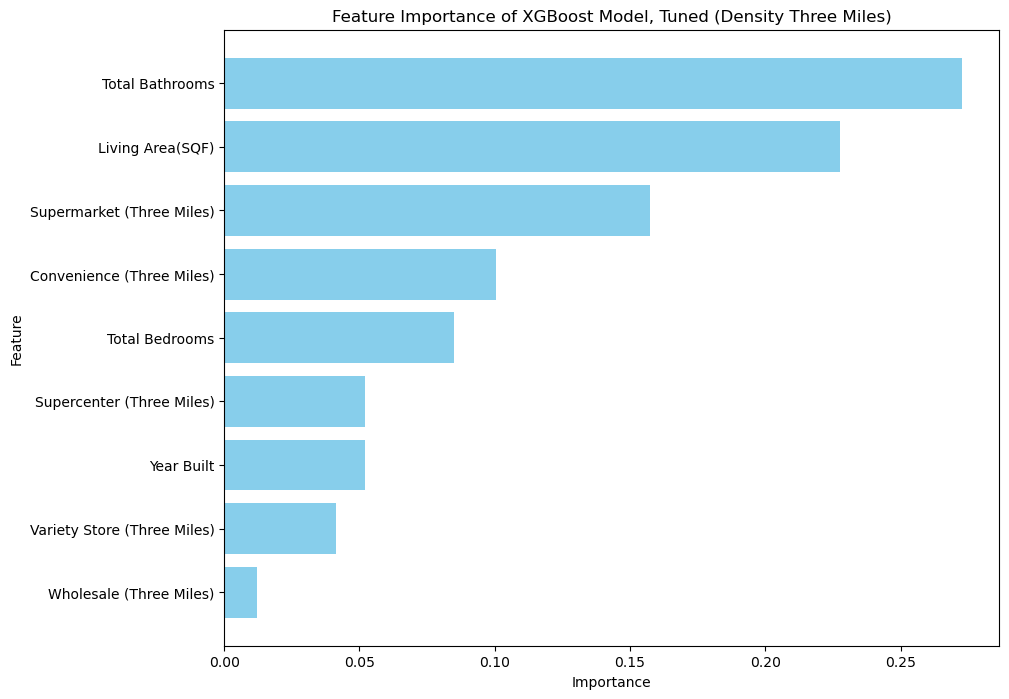

In [129]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_three, sorted_feature_importances_three, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Density Three Miles)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [130]:
all_feature_names_three

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale (Three Miles)',
 'Variety Store (Three Miles)',
 'Supermarket (Three Miles)',
 'Supercenter (Three Miles)',
 'Convenience (Three Miles)',
 'Total Bathrooms']

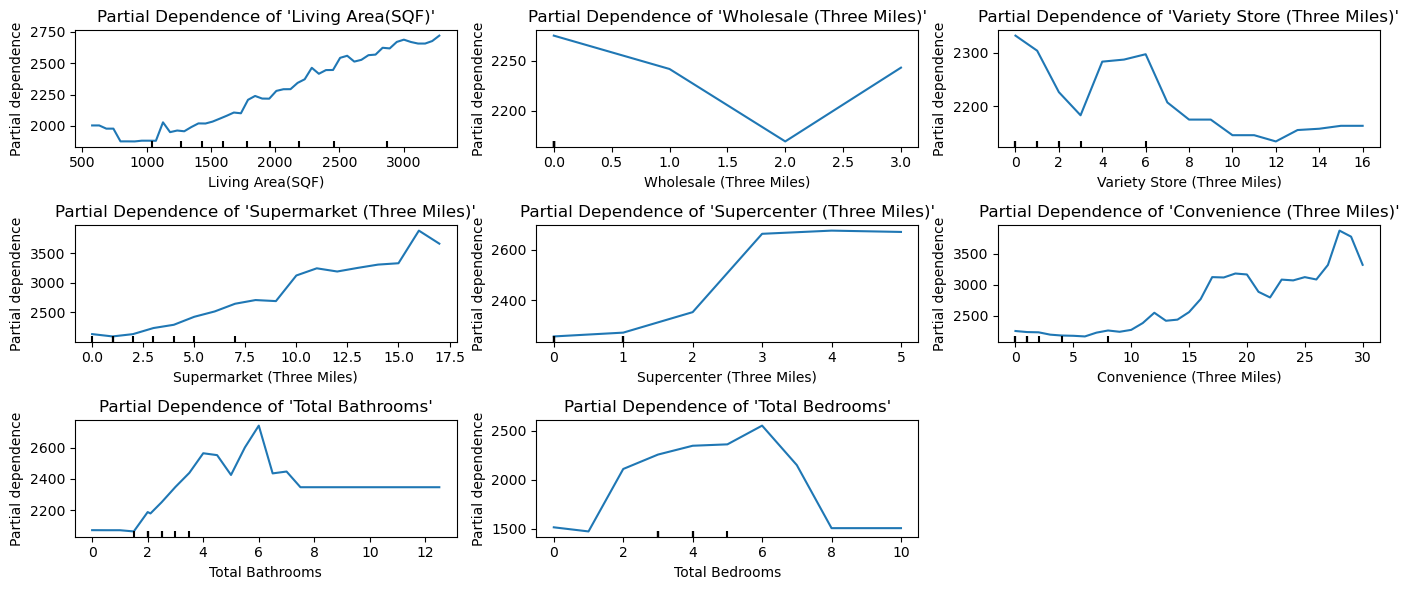

In [131]:
# List of features to include in the Partial Dependence Plots
features = [
'Living Area(SQF)', 'Wholesale (Three Miles)', 'Variety Store (Three Miles)', 'Supermarket (Three Miles)', 
    'Supercenter (Three Miles)', 'Convenience (Three Miles)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_three,
        X_train_val_three,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [132]:
Atlanta_Density_Five = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)',
                                                    'Wholesale (Three Miles)', 'Variety Store (Three Miles)','Supermarket (Three Miles)','Supercenter (Three Miles)', 'Convenience (Three Miles)'])
numeric_features_five = Atlanta_Density_Five.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer_five = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric and nominal
preprocessor_five = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_five, numeric_features_five),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data_five = preprocessor_five.fit_transform(Atlanta_Density_Five)

In [133]:
# Combine all feature names
all_feature_names_five = list(numeric_features_five)
transformed_df_five = pd.DataFrame(transformed_data_five, columns=all_feature_names_five)

In [134]:
# Assuming RandomForest is part of your models dictionary
xgb_model_five = XGBRegressor(random_state=42)
# Define the full model pipeline including the preprocessor
pipeline_five = Pipeline([
    ('preprocessor', preprocessor_five),
    ('regressor', xgb_model_five)
])
X_five = Atlanta_Density_Five.drop(columns='current_listing_price')
y_five = Atlanta_Density_Five['current_listing_price']

X_train_val_five, X_test_five, y_train_val_five, y_test_five = train_test_split(X_five, y_five, test_size=0.2, random_state=42)
X_train_five, X_val_five, y_train_five, y_val_five = train_test_split(X_train_val_five, y_train_val_five, test_size=0.25, random_state=42)

# Fit the model pipeline
pipeline_five.fit(X_train_five, y_train_five)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)',
       'Convenience (Five Miles)', 'Supercenter (Five Miles)',
       'Supermarket (Five Miles)', 'Variety Store (Five Miles)',
       'Wholesale (Five Miles)', 'Total Bathrooms'],
      dtype=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [135]:
val_score_five = pipeline_five.score(X_val_five, y_val_five) #0.6137914878103629
print('Validation R^2:', val_score_five)

test_score_five = pipeline_five.score(X_test_five, y_test_five) #0.55202185736604
print('Test R^2:', test_score_five)

Validation R^2: 0.6390162706375122
Test R^2: 0.6208189129829407


In [136]:
from sklearn.metrics import mean_squared_error #average squared difference between predicted and actual values
#When comparing different models, 
#the one with the lowest MSE on the validation or test set is generally considered to be the better model for predicting the target variable.

#Low RMSE values show that the model makes more accurate predictions and fits the data well
y_val_pred_five = pipeline_five.predict(X_val_five)

val_mse_five = mean_squared_error(y_val_five, y_val_pred_five)
print('Validation Mean Squared Error:', val_mse_five)
val_rmse_five = np.sqrt(val_mse_five)
print("Validation Root Mean Squared Error:", val_rmse_five)

y_test_pred_five = pipeline_five.predict(X_test_five)

test_mse_five = mean_squared_error(y_test_five, y_test_pred_five)
print('Test Mean Squared Error:', test_mse_five)
test_rmse_five = np.sqrt(test_mse_five)
print("Test Root Mean Squared Error:", test_rmse_five)

Validation Mean Squared Error: 301380.41893109435
Validation Root Mean Squared Error: 548.9812555371034
Test Mean Squared Error: 323682.2014066688
Test Root Mean Squared Error: 568.9307527341696


In [137]:
val_mape_five = calculate_mape(y_val_five, y_val_pred_five)
test_mape_five = calculate_mape(y_test_five, y_test_pred_five)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape_five)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape_five) #A lower MAPE value indicates a more accurate prediction

Validation Mean Absolute Percentage Error (MAPE): 13.774155873856623
Test Mean Absolute Percentage Error (MAPE): 14.00474794435663


In [138]:
param_grid_five = {
    'regressor__n_estimators': [500],       # Number of trees
    'regressor__learning_rate': [0.1],     # Learning rate (shrinkage)
    'regressor__max_depth': [3],                # Maximum depth of the trees
    'regressor__subsample': [1.0],               # Fraction of samples to be used per tree
    'regressor__colsample_bytree': [0.7],        # Fraction of features to be used per tree
    'regressor__alpha': [20],
    'regressor__gamma': [0.5]                # Minimum loss reduction for a split
}

grid_search_five = GridSearchCV(pipeline_five,
                           param_grid_five,
                           cv=10,
                           scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
                           refit='r2',
                           n_jobs=-1)

grid_search_five.fit(X_train_five, y_train_five)

best_model_five = grid_search_five.best_estimator_

# Access the results
results_five = grid_search_five.cv_results_
print("Best parameters:", grid_search_five.best_params_)
print("Best R^2:", grid_search_five.best_score_)


mean_r2_scores_five = results_five['mean_test_r2']
mean_mse_scores_five = -results_five['mean_test_neg_mean_squared_error']
mean_mape_scores_five = -results_five['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores_five = -results_five['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores_five)
print("Mean MAPE scores:", mean_mape_scores_five)
print("Mean R^2 scores:", mean_r2_scores_five)
print("Mean RMSE scores:", mean_RMSE_scores_five)

Best parameters: {'regressor__alpha': 20, 'regressor__colsample_bytree': 0.7, 'regressor__gamma': 0.5, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 500, 'regressor__subsample': 1.0}
Best R^2: 0.6141510307788849
Mean MSE scores: [315989.34011192]
Mean MAPE scores: [0.14346026]
Mean R^2 scores: [0.61415103]
Mean RMSE scores: [561.35321631]


In [139]:
y_val_pred_tuned_five = best_model_five.predict(X_val_five)
val_scores_five = calculate_scores(y_val_five, y_val_pred_tuned_five)

y_test_pred_tuned_five = best_model_five.predict(X_test_five)
test_scores_five = calculate_scores(y_test_five, y_test_pred_tuned_five)

y_combined_pred_tuned_five = best_model_five.predict(X_train_val_five)
combined_scores_five = calculate_scores(y_train_val_five, y_combined_pred_tuned_five)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_five[0]:.4f}")
print(f"MSE: {val_scores_five[1]:.4f}")
print(f"MAPE: {val_scores_five[2]:.4f}")
print(f"RMSE: {val_scores_five[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_five[0]:.4f}")
print(f"MSE: {test_scores_five[1]:.4f}")
print(f"MAPE: {test_scores_five[2]:.4f}")
print(f"RMSE: {test_scores_five[3]:.4f}")

print("\nTuned Test-Val Set Scores:")
print(f"R²: {combined_scores_five[0]:.4f}")
print(f"MSE: {combined_scores_five[1]:.4f}")
print(f"MAPE: {combined_scores_five[2]:.4f}")
print(f"RMSE: {combined_scores_five[3]:.4f}")
#Refitted model may be causing data leakage, and therefore different results. Differences can be ignored

Tuned Validation Set Scores:
R²: 0.6397
MSE: 300821.4735
MAPE: 0.1394
RMSE: 548.4719

Tuned Test Set Scores:
R²: 0.5968
MSE: 344173.7049
MAPE: 0.1437
RMSE: 586.6632

Tuned Test-Val Set Scores:
R²: 0.6953
MSE: 251218.1861
MAPE: 0.1332
RMSE: 501.2167


In [140]:
best_xgb_model_five = best_model_five.named_steps['regressor']
feature_importances_five = best_xgb_model_five.feature_importances_
sorted_indices_five = np.argsort(feature_importances_five)[::-1]
sorted_feature_importances_five = feature_importances_five[sorted_indices_five]
sorted_feature_names_five = np.array(all_feature_names_five)[sorted_indices_five]
for name, importance in zip(sorted_feature_names_five, sorted_feature_importances_five):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Total Bathrooms, Importance: 0.2614
Feature: Living Area(SQF), Importance: 0.2160
Feature: Supermarket (Five Miles), Importance: 0.1548
Feature: Convenience (Five Miles), Importance: 0.0950
Feature: Total Bedrooms, Importance: 0.0792
Feature: Wholesale (Five Miles), Importance: 0.0683
Feature: Supercenter (Five Miles), Importance: 0.0487
Feature: Year Built, Importance: 0.0418
Feature: Variety Store (Five Miles), Importance: 0.0350


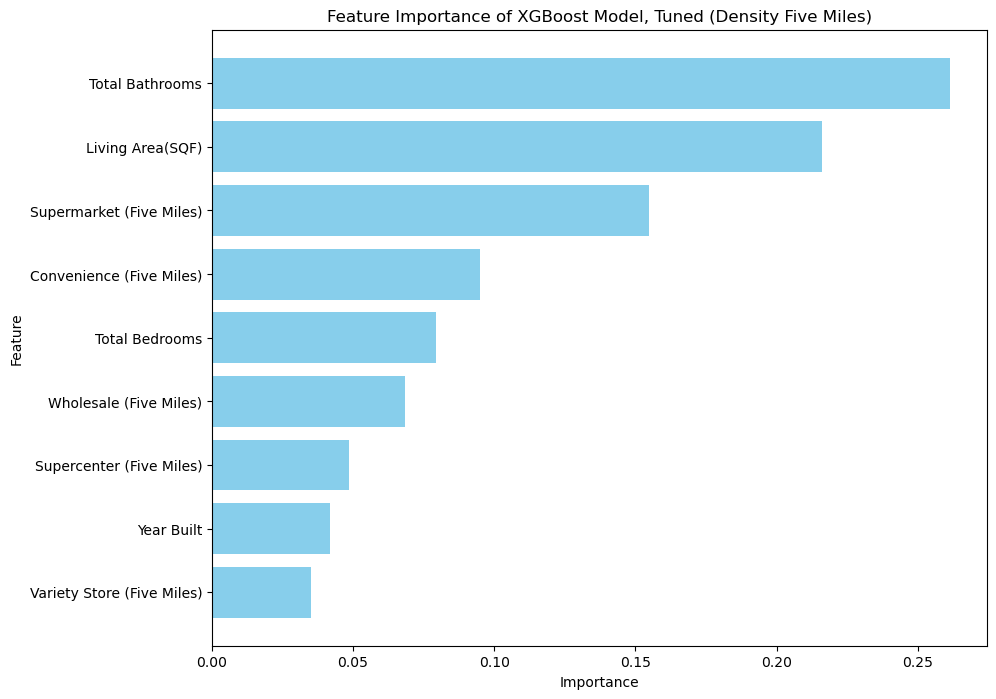

In [141]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_five, sorted_feature_importances_five, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Density Five Miles)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

In [142]:
all_feature_names_five

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Convenience (Five Miles)',
 'Supercenter (Five Miles)',
 'Supermarket (Five Miles)',
 'Variety Store (Five Miles)',
 'Wholesale (Five Miles)',
 'Total Bathrooms']

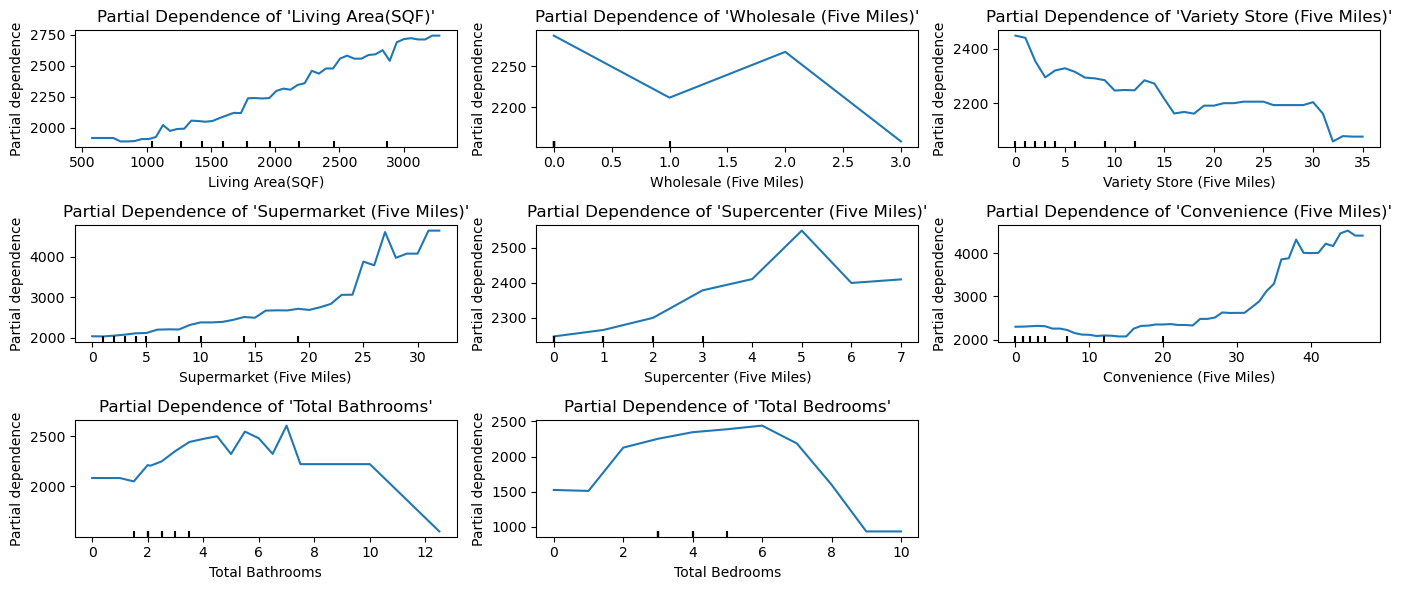

In [143]:
# List of features to include in the Partial Dependence Plots
features = [
 'Living Area(SQF)', 'Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 
    'Supercenter (Five Miles)', 'Convenience (Five Miles)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_five,
        X_train_val_five,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [182]:
Atlanta_Density_One_b = Atlanta_Density_One.drop(columns=['Convenience (One Mile)','Supercenter (One Mile)','Supermarket (One Mile)','Variety Store (One Mile)','Wholesale (One Mile)',])
Atlanta_Density_One_b = Atlanta_Density_One_b.groupby(["street_address"])[['Year Built','Total Bedrooms','Living Area(SQF)','Total Bathrooms', 'current_listing_price']].max().reset_index(drop = False)
numeric_features_b = Atlanta_Density_One_b.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
preprocessor_b = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_b),
        #('nominal', categorical_transformer, categorical_features)
])
transformed_data_b = preprocessor_b.fit_transform(Atlanta_Density_One_b)
all_feature_names_b = list(numeric_features_b)
transformed_df_b = pd.DataFrame(transformed_data_b, columns=all_feature_names_b)
transformed_df_b

,Year Built,Total Bedrooms,Living Area(SQF),Total Bathrooms
0,5.068264e-01,0.670187,1.319220,0.189453
1,1.073134e-14,-0.440415,0.101174,-0.465279
2,1.073134e-14,-0.440415,0.021318,-0.465279
3,1.073134e-14,-0.440415,-0.725288,-1.774741
4,1.073134e-14,0.670187,0.619757,-0.465279
...,...,...,...,...
19213,1.073134e-14,-0.440415,-0.501114,-0.465279
19214,1.073134e-14,-0.440415,-0.184576,0.189453
19215,1.120386e+00,-0.440415,0.054030,1.498915
19216,1.073134e-14,0.670187,-0.657940,-0.465279


In [183]:
xgb_model = XGBRegressor(random_state=42)
pipeline_b = Pipeline([
    ('preprocessor', preprocessor_b),
    ('regressor', xgb_model)
])
X_b = Atlanta_Density_One_b.drop(columns='current_listing_price')
y_b = Atlanta_Density_One_b['current_listing_price']

X_train_val_b, X_test_b, y_train_val_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_val_b, y_train_val_b, test_size=0.25, random_state=42)

# Fit the model pipeline
pipeline_b.fit(X_train_b, y_train_b)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Total Bathrooms'], dtype='object'))])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [184]:
val_score_b = pipeline_b.score(X_val_b, y_val_b)
print('Validation R^2:', val_score_b)
 
test_score_b = pipeline_b.score(X_test_b, y_test_b)
print('Test R^2:', test_score_b)

Validation R^2: 0.38495951890945435
Test R^2: 0.4431343078613281


In [185]:
param_grid_b = {
    'regressor__n_estimators': [200],
    'regressor__learning_rate': [0.05],
    'regressor__max_depth': [6],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8],
    'regressor__alpha': [10],
    'regressor__lambda': [10]
}


grid_search_b = GridSearchCV(pipeline_b,
                           param_grid_b,
                           cv=10,
                           scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],# Multiple scoring
                           refit='r2',
                           n_jobs=-1)

grid_search_b.fit(X_train_b, y_train_b)

best_model_b = grid_search_b.best_estimator_
results_b = grid_search_b.cv_results_
print("Best parameters:", grid_search_b.best_params_)
print("Best R^2:", grid_search_b.best_score_)

Best parameters: {'regressor__alpha': 10, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 10, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Best R^2: 0.4074162244796753


In [186]:
y_val_pred_tuned_b = best_model_b.predict(X_val_b)
val_scores_b = calculate_scores(y_val_b, y_val_pred_tuned_b)

y_test_pred_tuned_b = best_model_b.predict(X_test_b)
test_scores_b = calculate_scores(y_test_b, y_test_pred_tuned_b)

y_combined_pred_tuned_b = best_model_b.predict(X_train_val_b)
combined_scores_b = calculate_scores(y_train_val_b, y_combined_pred_tuned_b)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_b[0]:.4f}")
print(f"MSE: {val_scores_b[1]:.4f}")
print(f"MAPE: {val_scores_b[2]:.4f}")
print(f"RMSE: {val_scores_b[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_b[0]:.4f}")
print(f"MSE: {test_scores_b[1]:.4f}")
print(f"MAPE: {test_scores_b[2]:.4f}")
print(f"RMSE: {test_scores_b[3]:.4f}")

print("\nTuned Test-Val Set Scores:")
print(f"R²: {combined_scores_b[0]:.4f}")
print(f"MSE: {combined_scores_b[1]:.4f}")
print(f"MAPE: {combined_scores_b[2]:.4f}")
print(f"RMSE: {combined_scores_b[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.4230
MSE: 539501.9158
MAPE: 0.1741
RMSE: 734.5079

Tuned Test Set Scores:
R²: 0.4779
MSE: 439828.0931
MAPE: 0.1694
RMSE: 663.1954

Tuned Test-Val Set Scores:
R²: 0.5080
MSE: 404398.7268
MAPE: 0.1628
RMSE: 635.9235


In [187]:
best_xgb_model_b = best_model_b.named_steps['regressor']
feature_importances_b = best_xgb_model_b.feature_importances_
sorted_indices_b = np.argsort(feature_importances_b)[::-1]
sorted_feature_importances_b = feature_importances_b[sorted_indices_b]
sorted_feature_names_b = np.array(all_feature_names_b)[sorted_indices_b]
for name, importance in zip(sorted_feature_names_b, sorted_feature_importances_b):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.4078
Feature: Total Bathrooms, Importance: 0.3188
Feature: Year Built, Importance: 0.1453
Feature: Total Bedrooms, Importance: 0.1280


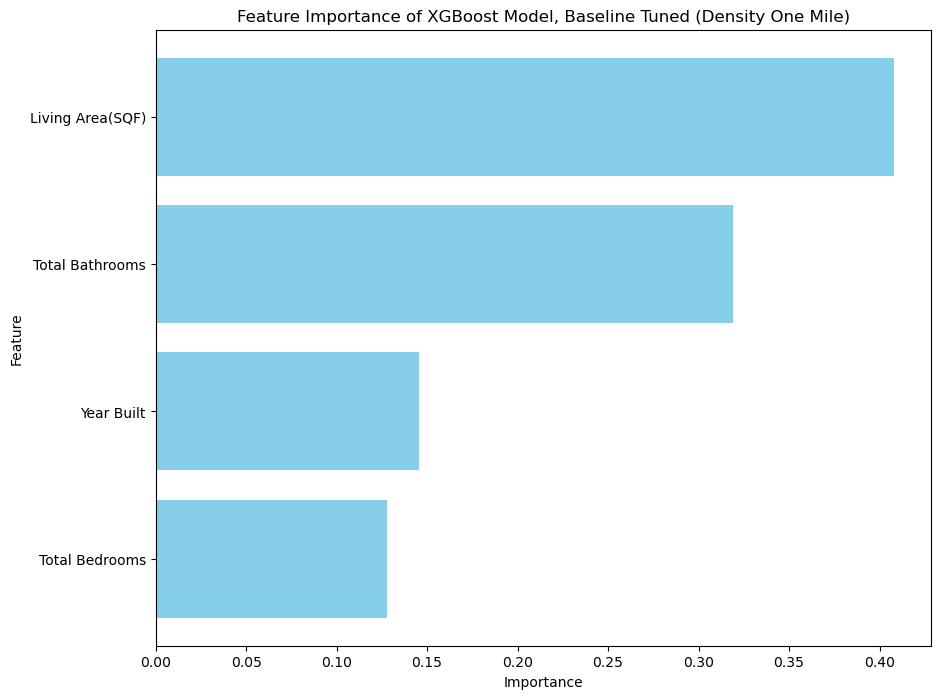

In [188]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_b, sorted_feature_importances_b, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Baseline Tuned (Density One Mile)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

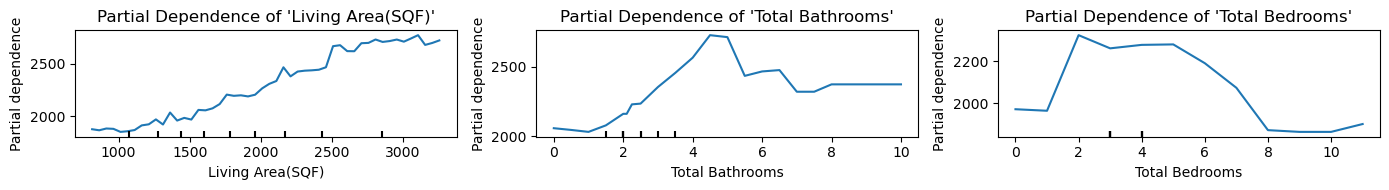

In [189]:
# List of features to include in the Partial Dependence Plots
features = [
 'Living Area(SQF)', 'Total Bathrooms', 'Total Bedrooms']

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_b,
        X_train_val_b,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()